# Analizador de texto en Python: Bag of Words

* * * 
<div class="alert alert-success">  
    
### Objetivos de Aprendizaje 
    
* Aprender cómo convertir datos de texto en números mediante el enfoque de Bag-of-Words (Bolsa de Palabras).
* Comprender el algoritmo TF-IDF y cómo complementa la representación Bag-of-Words.
* Implementar Bag-of-Words y TF-IDF usando el paquete `sklearn` y entender la configuración de sus parámetros.
* Usar las representaciones numéricas de los datos de texto para realizar análisis de sentimientos.
</div>

### Íconos Usados en Este Notebook
🔔 **Pregunta**: Una pregunta rápida para ayudarte a entender lo que está ocurriendo.<br>
🥊 **Desafío**: Ejercicio interactivo. ¡Trabajaremos en ellos durante el taller!<br>
🎬 **Demostración**: Mostrando algo más avanzado – ¡para que sepas para qué puede usarse Python!<br> 

### Secciones
1. [Análisis Exploratorio de Datos](#section1)
2. [Preprocesamiento](#section2)
3. [La Representación Bag-of-Words](#section3)
4. [Frecuencia de Término - Frecuencia Inversa de Documento (TF-IDF)](#section4)
5. [Clasificación de Sentimientos Usando la Representación TF-IDF](#section5)

En la parte anterior, aprendimos cómo realizar el preprocesamiento de texto. Sin embargo, no fuimos más allá de los datos de texto en sí. Si estamos interesados en hacer algún análisis computacional sobre los datos de texto, todavía necesitamos enfoques para convertir ese texto en una **representación numérica**.

En la Parte 2 de nuestra serie de talleres, exploraremos una de las formas más sencillas de generar una representación numérica a partir del texto: el enfoque de **bag-of-words** (Bolsa de Palabras o BoW). Implementaremos la representación BoW para transformar nuestros datos de tweets sobre aerolíneas, y luego construiremos un clasificador para explorar qué nos dice sobre el sentimiento de los tweets. En el corazón del enfoque bag-of-words se encuentra la suposición de que la frecuencia de ciertos tokens es informativa sobre la semántica y el sentimiento subyacente en el texto.

Usaremos ampliamente el paquete `scikit-learn` para hacerlo, ya que proporciona un buen marco para construir la representación numérica.

¡Primero instalemos `scikit-learn`!

In [ ]:
# Decomenta e intalla el paquete
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Descomenta e install el paquete NLP packages introducido en la parte 1
%pip install NLTK
%pip install spaCy
!python -m spacy download en_core_web_sm
!pip install pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.2 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 154.3 MB/s eta 0:00:00


In [ ]:
# Importa otros paquetes necesarios
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline


<a id='section1'></a>

# Análisis Exploratorio de Datos

Antes de realizar cualquier tipo de preprocesamiento o modelado, siempre debemos llevar a cabo un análisis exploratorio de datos para familiarizarnos con la información.


In [ ]:
# Leer los datos
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [8]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Como recordatorio, cada fila en este dataframe corresponde a un tweet. Las siguientes columnas son las que más nos interesan. Hay otras columnas que contienen metadatos del tweet, como el autor, la fecha de creación, la zona horaria del usuario, entre otros, que dejaremos de lado por ahora.

- `text` (`str`): el texto del tweet.
- `airline_sentiment` (`str`): el sentimiento del tweet, etiquetado como "neutral", "positive" o "negative".
- `airline` (`str`): la aerolínea sobre la que se tuitea.
- `retweet count` (`int`): cuántas veces fue retuiteado el tweet.

Para prepararnos para la clasificación de sentimientos, vamos a dividir el conjunto de datos y enfocarnos por ahora en los tweets "positivos" y "negativos".

In [9]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

Vamos a echar un vistazo a algunos tweets primero.

In [ ]:
# Imprimimos 5 tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


¡Ya podemos ver que algunos de estos tweets contienen sentimiento negativo! ¿Cómo podemos darnos cuenta de esto?

A continuación, veamos la distribución de etiquetas de sentimiento en este conjunto de datos.

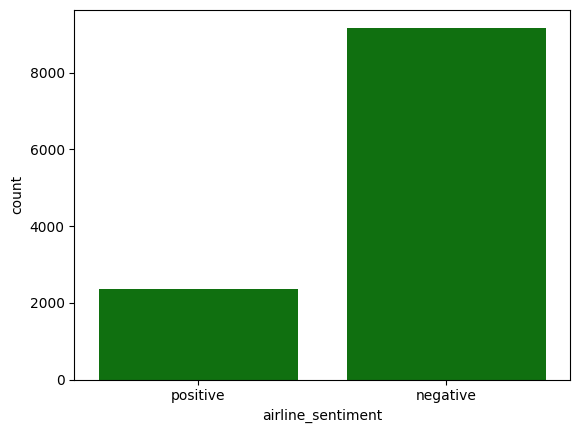

In [ ]:
# Hacemos un grafico de la cantidad de tweet de los sentimientos
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='green',
              order=['positive', 'negative']);

¡Parece que la mayoría de los tweets en este conjunto de datos expresan un sentimiento negativo!

Veamos ahora qué tipo de tweets se retuitean más:

In [ ]:
# Obtenemos el recuento promedio de retweet de cada sentimiento
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

Los tweets negativos son claramente mas que los positivos
Vamos a ver que aerolina recive mas tweets negativos:

In [ ]:
# Obtenemos la porcion de tweets negativos por aerolinea
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


¡Parece que las personas están más insatisfechas con US Airways, seguida de American Airlines, ambas con más del 85% de tweets negativos!

Se podrían hacer muchos descubrimientos interesantes si deseas explorar más sobre los datos. Ahora volvamos a nuestra tarea de análisis de sentimientos. Antes de eso, necesitamos preprocesar

<a id='section2'></a>
# Preprocesamiento

Pasamos gran parte de la Parte 1 aprendiendo cómo preprocesar datos. ¡Vamos a aplicar lo que aprendimos! Al observar algunos de los tweets anteriores, podemos ver que, aunque están en bastante buen estado, aún podemos realizar un procesamiento adicional sobre ellos.

En nuestra canalización (pipeline), omitiremos el proceso de tokenización ya que lo realizaremos en un paso posterior.

## 🥊 Desafío 1: Aplicar una Canalización de Limpieza de Texto

Escribe una función llamada `preprocess` que realice los siguientes pasos sobre un texto de entrada:

* Paso 1: Convertir todo el texto a minúsculas.
* Paso 2: Reemplazar los siguientes patrones por marcadores de posición:
    * URLs &rarr; ` URL `
    * Dígitos &rarr; ` DIGIT `
    * Hashtags &rarr; ` HASHTAG `
    * Menciones (handles) &rarr; ` USER `
* Paso 3: Eliminar espacios en blanco extra.

Aquí tienes algunas pistas para guiarte en este desafío:

* Para el Paso 1, recuerda de la Parte 1 que existe un método de cadena llamado [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) que puede usarse para convertir texto a minúsculas.
* Hemos integrado el Paso 2 en una función llamada `placeholder`. Ejecuta la celda de abajo para importarla en tu notebook, y podrás usarla como cualquier otra función.
* Para el Paso 3, te proporcionamos el patrón regex para identificar caracteres de espacio en blanco, así como el reemplazo correcto para eliminar espacios extra.

Ejecuta tu función `preprocess` sobre `example_tweet` (tres celdas más abajo) para verificar si funciona. Si lo hace, aplícala a toda_

In [44]:
from utils import placeholder

In [ ]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Crear una canalización de preprocesamiento que limpie los datos de los tweets.'''
    
    # Paso 1: Convertir a minúsculas
    text = ...

    # Paso 2: Reemplazar patrones con marcadores de posición
    text = ...

    # Paso 3: Eliminar caracteres de espacio en blanco extra
    text = ...

    return text

In [ ]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

# Imprimir el ejemplo de tweet
print(example_tweet)
print(f"{'='*50}")

# Imprimir el preproceso del tweet
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
Ellipsis


In [ ]:
# Aplicar la función a la columna de texto y asignar los tweets preprocesados a una nueva columna
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    Ellipsis
1    Ellipsis
2    Ellipsis
3    Ellipsis
4    Ellipsis
Name: text_processed, dtype: object

¡Felicidades! El preprocesamiento está completo. ¡Vamos a sumergirnos en el bag-of-words!

<a id='section3'></a>
# La Representación Bag-of-Words

La idea del enfoque bag-of-words (BoW), como sugiere el nombre, es bastante intuitiva: tomamos un documento y lo "lanzamos" a una bolsa. El acto de "arrojar" el documento a una bolsa ignora la posición relativa entre las palabras, por lo que lo que queda "en la bolsa" es esencialmente un "conjunto desordenado de palabras" [(Jurafsky & Martin, 2024)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). A cambio, obtenemos una lista de palabras únicas y la frecuencia de cada una de ellas.

Por ejemplo, como se muestra en la siguiente ilustración, la palabra "coffee" aparece dos veces.

<img src='../images/bow-illustration-1.png' alt="BoW-Part2" width="600">

Con una representación bag-of-words, hacemos un uso intensivo de la frecuencia de las palabras, pero no tanto del orden en que aparecen.

En el contexto del análisis de sentimientos, el sentimiento de un tweet se transmite con más fuerza a través de palabras específicas. Por ejemplo, si un tweet contiene la palabra "happy" (feliz), probablemente exprese un sentimiento positivo, aunque no siempre (por ejemplo, "not happy" denota el sentimiento opuesto). Cuando estas palabras aparecen con más frecuencia, probablemente transmitan con más fuerza el sentimiento.

## Matriz Documento-Término

Ahora implementemos la idea de bag-of-words. Antes de profundizar más, retrocedamos un momento. En la práctica, el análisis de texto a menudo implica manejar muchos documentos; a partir de ahora, usaremos el término **documento** para representar un fragmento de texto sobre el cual realizamos análisis. Puede ser una frase, una oración, un tweet u otro tipo de texto—mientras pueda representarse como una cadena de texto, la longitud no importa realmente.

Imagina que tenemos cuatro documentos (es decir, las cuatro frases mostradas arriba), y los lanzamos todos a la bolsa. En lugar de obtener una lista de frecuencias de palabras, obtendremos como resultado una matriz documento-término (DTM, por sus siglas en inglés). En una DTM, la lista de palabras es el **vocabulario** (V), que contiene todas las palabras únicas que aparecen en los documentos. Para cada **documento** (D), contamos cuántas veces aparece cada palabra del vocabulario, y luego colocamos ese número en la matriz. En otras palabras, la DTM que construiremos es una matriz de tamaño $D \times V$, donde cada fila corresponde a un documento, y cada columna corresponde a un token (o "término").

Los tokens únicos en este conjunto de documentos, ordenados alfabéticamente, forman las columnas. Para cada documento, marcamos la aparición de cada palabra presente. La representación numérica de cada documento es una fila de la matriz. Por ejemplo, el primer documento, "the coffee roaster", tiene la representación numérica $[0, 1, 0, 0, 0, 1, 1, 0]$.

Nota que la columna de índice a la izquierda muestra estos documentos como texto, pero normalmente simplemente asignaríamos un índice a cada uno.

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

Para crear una DTM, utilizaremos `CountVectorizer` del paquete `sklearn`.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustración muestra el flujo de trabajo en tres pasos para crear una DTM con `CountVectorizer`.

<img src='../images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Vamos a recorrer estos pasos utilizando el ejemplo simple mostrado arriba.


### Un ejemplo de juego

In [19]:
# A toy example containing four documents
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto `CountVectorizer`. Dentro de los paréntesis, podemos especificar configuraciones de parámetros si lo deseamos. Echemos un vistazo a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para ver qué opciones están disponibles.

Por ahora, podemos dejarlo en blanco para usar la configuración predeterminada.

In [20]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

El segundo paso es aplicar el método `fit` al objeto `CountVectorizer` con los datos, lo que significa crear un vocabulario de tokens a partir del conjunto de documentos. En tercer lugar, usamos `transform` sobre nuestros datos usando el objeto `CountVectorizer` ya "ajustado", lo que implica tomar cada documento y contar las ocurrencias de los tokens según el vocabulario establecido durante el paso de "ajuste" (`fit`).

Puede sonar un poco complejo, pero los pasos 2 y 3 se pueden realizar de una sola vez usando la función `fit_transform`.

In [21]:
# Fit and transform to create a DTM
test_count = vectorizer.fit_transform(test)

El resultado de `fit_transform` debería ser la DTM (Matriz Documento-Término).

¡Vamos a echarle un vistazo!

In [22]:
test_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (4, 8)>

Aparentemente, lo que obtuvimos es una "matriz dispersa" (sparse matrix), es decir, una matriz que contiene muchos ceros. Esto tiene sentido. Para cada documento, hay palabras que no aparecen en absoluto, y estas se contabilizan como ceros en la DTM. Esta matriz dispersa se almacena en un formato llamado "Compressed Sparse Row" (CSR), un formato optimizado para ahorrar memoria al manejar matrices dispersas.

Vamos a convertirla en una matriz densa, donde probablemente esos ceros estén representados, como en un array de NumPy.

In [23]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¡Así que esta es nuestra DTM! La matriz es la misma que mostramos anteriormente. Para que sea más fácil de leer, vamos a convertirla en un dataframe. Los nombres de las columnas deben ser los tokens del vocabulario, los cuales podemos obtener con la función `get_feature_names_out`.

In [24]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [25]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¡Aquí está! La DTM de nuestros datos de ejemplo ahora es un dataframe. El índice de `test_dtm` corresponde a la posición de cada documento en la lista `test`.

In [26]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Esperamos que este ejemplo sencillo haya servido como una guía clara para crear una DTM.

¡Ahora es momento de trabajar con nuestros datos de tweets!

### DTM para Tweets

Comenzaremos inicializando un objeto `CountVectorizer`. En la siguiente celda, hemos incluido algunos parámetros que la gente suele ajustar. Estos parámetros están actualmente configurados con sus valores predeterminados.

Cuando construimos una DTM, el comportamiento por defecto es convertir el texto de entrada a minúsculas. Si no se proporciona nada en `stop_words`, el valor por defecto es conservarlas. Los siguientes tres parámetros se utilizan para controlar el tamaño del vocabulario, a los cuales volveremos en un momento.


In [ ]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)
print(tweets['text_processed'].dtype)  # Tipo de datos de la columna
print(tweets['text_processed'].head())  # Muestra las primeras filas
print(tweets['text_processed'].apply(type).value_counts())  # Tipos de valores en la columna

# prueba
from utils import placeholder
 
blankspace_pattern = r'\s+'
blankspace_repl = ' '
 
def preprocess(text):
    # Step 1: Minusculas
    text = text.lower()
 
    # Step 2: Renplazar patrones con marcadores de posición
    text = placeholder(text)
 
    # Step 3: Remover los caracteres con espacios extras
    text = re.sub(blankspace_pattern, blankspace_repl, text).strip()
 
    return text
 
tweets['text_processed'] = tweets['text'].apply(preprocess)

object
0    Ellipsis
1    Ellipsis
2    Ellipsis
3    Ellipsis
4    Ellipsis
Name: text_processed, dtype: object
text_processed
<class 'ellipsis'>    11541
Name: count, dtype: int64


In [ ]:
# Ajustar y transformar para crear la DTM
counts = vectorizer.fit_transform(tweets['text_processed'].fillna(''))
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 191139 stored elements and shape (11541, 8751)>

In [ ]:
# No ejecutes esto si tienes memoria limitada — esto incluye DataHub y Binder.
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11541, 8751))

In [ ]:
# Extraer tokens
tokens = vectorizer.get_feature_names_out()

In [ ]:
# Crear DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Imprimir la forma (shape) de la DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos `CountVectorizer` con la configuración predeterminada, el tamaño del vocabulario en los datos de tweets es de 8751.

In [50]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadv,aadvantage,aal,aaron,ab,aback,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La mayoría de los tokens tienen cero apariciones al menos en los primeros cinco tweets.

¡Echemos un vistazo más de cerca a la DTM!

In [ ]:
# tokens mas frecuentes
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

In [ ]:
# Tokens menos frecuentes
first_dtm.sum().sort_values(ascending=True).head(10)

zones         1
accelerate    1
acc           1
acarl         1
yogurt        1
yoga          1
yikes         1
absurdity     1
absorber      1
absorb        1
dtype: int64

No es sorprendente ver que "user" y "digit" estén entre los tokens más frecuentes, ya que reemplazamos cada uno de los elementos idiosincráticos con estos marcadores de posición. El resto de los tokens más frecuentes son en su mayoría palabras vacías (stop words).

Quizás un patrón más interesante sea buscar qué token aparece más en un tweet determinado:

In [ ]:
counts = pd.DataFrame()

# Obtener el índice del tweet donde un token aparece con mayor frecuencia
counts['token'] = first_dtm.idxmax(axis=1)

# Obtener el número de ocurrencias
counts['number'] = first_dtm.max(axis=1)

# Filtrar los marcadores de posición
counts[(counts['token'] != 'digit')
       & (counts['token'] != 'hashtag')
       & (counts['token'] != 'user')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
11007,to,5
5513,to,5
7750,to,5
10923,the,5
4089,to,5
8134,to,5
8148,the,5
557,to,5


Parece que, entre todos los tweets, como máximo un token aparece seis veces, y es o bien la palabra "It" o la palabra "worst".

Volvamos a nuestro dataframe de tweets y localicemos el tweet número 918.

In [54]:
# Retrieve 918th tweet: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Personalizar el `CountVectorizer`

Hasta ahora hemos utilizado siempre la configuración predeterminada para crear nuestras DTM, pero en muchos casos podríamos querer personalizar el objeto `CountVectorizer`. El propósito de hacerlo es filtrar aún más los tokens innecesarios. En el siguiente ejemplo, ajustamos los siguientes parámetros:

- `stop_words = 'english'`: ignora las palabras vacías en inglés  
- `min_df = 2`: ignora las palabras que no aparecen al menos dos veces  
- `max_df = 0.95`: ignora las palabras que aparecen en más del 95% de los documentos  

🔔 **Pregunta**: ¡Pausamos un momento para discutir si tiene sentido establecer estos parámetros! ¿Qué opinas?

A menudo, no nos interesan las palabras cuya frecuencia es demasiado baja o demasiado alta, por eso usamos `min_df` y `max_df` para filtrarlas. Alternativamente, podemos definir el tamaño de nuestro vocabulario como $N$ usando `max_features`. En otras palabras, le indicamos a `CountVectorizer` que solo considere los $N$ tokens más frecuentes al construir la DTM.

In [55]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [56]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestra segunda DTM tiene un vocabulario sustancialmente más pequeño en comparación con la primera.

In [57]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [58]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La lista de tokens más frecuentes ahora incluye palabras que tienen más sentido para nosotros, como "cancelled" y "service".

In [59]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

## 🥊 Desafío 2: Lematizar el Texto de Entrada

Recuerda que en la Parte 1 presentamos cómo usar `spaCy` para realizar lematización, es decir, "recuperar" la forma base de una palabra. Este proceso ayuda a reducir el tamaño del vocabulario manteniendo al mínimo las variaciones de una palabra—un vocabulario más pequeño puede mejorar el rendimiento del modelo en la clasificación de sentimientos.

Ahora implementaremos la lematización en nuestros datos de tweets y usaremos el texto lematizado para crear una tercera DTM.

Completa la función `lemmatize_text`. Esta función recibe un texto como entrada y devuelve los lemas de todos los tokens.

Aquí tienes algunas pistas para ayudarte en este desafío:

- Paso 1: inicializa una lista para almacenar los lemas  
- Paso 2: aplica la canalización `nlp` al texto de entrada  
- Paso 3: itera sobre los tokens en el texto procesado y recupera el lema de cada token  
    - PISTA: la lematización es una de las anotaciones lingüísticas que la canalización `nlp` realiza automáticamente. Podemos usar `token.lemma_` para acceder a esa anotación.
